### Task 2: Use the converted weights and compare the fine-tuning results on CIFAR-10 dataset.
* Training from scratch
* ImageNet weights
* SimCLR pre-trained model 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import timm
import detectors

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)

val_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=4)

# Create the models
model_scratch = models.resnet50(pretrained=False)
model_imagenet = models.resnet50(pretrained=True)
model_simclr = timm.create_model("resnet50_simclr_cifar10", pretrained=True)

# Replace the last layer
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = nn.Linear(num_ftrs, 10)
model_imagenet.fc = nn.Linear(num_ftrs, 10)
model_simclr.fc = nn.Linear(num_ftrs, 10)

# Move models to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_scratch = model_scratch.to(device)
model_imagenet = model_imagenet.to(device)
model_simclr = model_simclr.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
optimizer_imagenet = optim.SGD(model_imagenet.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
optimizer_simclr = optim.SGD(model_simclr.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# Training function
def train_model(model, optimizer, num_epochs=10):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        loss_train = 0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            loss_history.append(loss_train/len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_train/len(train_loader):.4f}")
    return loss_history

# Validation function
def validate_model(model):
    model.eval()
    correct = 0
    total = 0
    acc_history = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    acc_history.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.2f}%")
    return acc_history
 
loss_dict = {}
acc_dict = {}

# Train and validate models
print("Training model from scratch:")
loss_dict['resnet50_no_pretrain_loos'] = train_model(model_scratch, optimizer_scratch)
acc_dict['resnet50_no_pretraint_acc'] = validate_model(model_scratch)

print("Training model with ImageNet pre-trained weights:")
loss_dict['resnet50_pretraint_loss'] = train_model(model_imagenet, optimizer_imagenet)
acc_dict['resnet50_pretraint_acc'] = validate_model(model_imagenet)

#print("Training model with SimCLR pre-trained weights:")
loss_dict['resnet50_simclr_loss'] = train_model(model_simclr, optimizer_simclr)
acc_dict['resnet50_simclr_acc'] = validate_model(model_simclr)

# Freezing/unfreezing layers experiment
def freeze_layers(model):
    for param in model.parameters():
        param.requires_grad = False

# Example of freezing layers
print("Freezing layers of the ImageNet pre-trained model:")
freeze_layers(model_imagenet)
model_imagenet.fc = nn.Linear(num_ftrs, 10).to(device)  # Ensure the final layer is trainable and moved to GPU
optimizer_imagenet = optim.SGD(model_imagenet.fc.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
loss_dict['resnet50_pretraint_freeze_loss'] = train_model(model_imagenet, optimizer_imagenet)
acc_dict['resnet50_pretraint_freeze_acc'] = validate_model(model_imagenet)

# Example of unfreezing layers after initial training
print("Unfreezing layers of the ImageNet pre-trained model:")
for param in model_imagenet.parameters():
    param.requires_grad = True
optimizer_imagenet = optim.SGD(model_imagenet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
loss_dict['resnet50_pretraint_unfreeze_loss'] = train_model(model_imagenet, optimizer_imagenet)
acc_dict['resnet50_pretraint_unfreeze_acc']= validate_model(model_imagenet)


Files already downloaded and verified
Files already downloaded and verified


/home/78c9/MasterStudium/PythonEnvironment/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/78c9/MasterStudium/PythonEnvironment/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/78c9/MasterStudium/PythonEnvironment/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.wa

Training model from scratch:
Epoch [1/10], Loss: 4.5148
Epoch [2/10], Loss: 2.0488
Epoch [3/10], Loss: 1.8662
Epoch [4/10], Loss: 1.7352
Epoch [5/10], Loss: 1.6239
Epoch [6/10], Loss: 1.5193
Epoch [7/10], Loss: 1.4342
Epoch [8/10], Loss: 1.3648
Epoch [9/10], Loss: 1.2964
Epoch [10/10], Loss: 1.2414
Validation Accuracy: 53.62%
Training model with ImageNet pre-trained weights:
Epoch [1/10], Loss: 2.8179
Epoch [2/10], Loss: 1.9603
Epoch [3/10], Loss: 1.7329
Epoch [4/10], Loss: 1.5325
Epoch [5/10], Loss: 1.4435
Epoch [6/10], Loss: 1.3565
Epoch [7/10], Loss: 1.2809
Epoch [8/10], Loss: 1.2036
Epoch [9/10], Loss: 1.1268
Epoch [10/10], Loss: 1.0656
Validation Accuracy: 62.43%


/home/78c9/MasterStudium/PythonEnvironment/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/10], Loss: 0.4091
Epoch [2/10], Loss: 0.2296
Epoch [3/10], Loss: 0.1632
Epoch [4/10], Loss: 0.1391
Epoch [5/10], Loss: 0.1180
Epoch [6/10], Loss: 0.1016
Epoch [7/10], Loss: 0.1002
Epoch [8/10], Loss: 0.0854
Epoch [9/10], Loss: 0.0792
Epoch [10/10], Loss: 0.0809
Validation Accuracy: 87.88%
Freezing layers of the ImageNet pre-trained model:
Epoch [1/10], Loss: 0.9792
Epoch [2/10], Loss: 0.9281
Epoch [3/10], Loss: 0.9225
Epoch [4/10], Loss: 0.9169
Epoch [5/10], Loss: 0.9141
Epoch [6/10], Loss: 0.9113
Epoch [7/10], Loss: 0.9087
Epoch [8/10], Loss: 0.9052
Epoch [9/10], Loss: 0.9038
Epoch [10/10], Loss: 0.9050
Validation Accuracy: 64.26%
Unfreezing layers of the ImageNet pre-trained model:
Epoch [1/10], Loss: 0.8611
Epoch [2/10], Loss: 0.8101
Epoch [3/10], Loss: 0.7829
Epoch [4/10], Loss: 0.7551
Epoch [5/10], Loss: 0.7247
Epoch [6/10], Loss: 0.6985
Epoch [7/10], Loss: 0.6688
Epoch [8/10], Loss: 0.6406
Epoch [9/10], Loss: 0.6128
Epoch [10/10], Loss: 0.5822
Validation Accuracy: 67.99%

In [8]:
loss_dict['resnet50_simclr_loss'] 

[0.00460230827331543,
 0.009147738456726074,
 0.01358428430557251,
 0.01786226177215576,
 0.022001344203948975,
 0.025852458715438842,
 0.029586618661880493,
 0.032798782348632816,
 0.035985157251358035,
 0.03871256017684937,
 0.04112863087654114,
 0.043145212650299074,
 0.04495945644378662,
 0.04654396295547485,
 0.04797499883174896,
 0.049333728551864624,
 0.05040777814388275,
 0.05147160935401916,
 0.05235634154081344,
 0.05317892777919769,
 0.053684769928455355,
 0.0543248827457428,
 0.05471883609890938,
 0.055365312486886975,
 0.05629214116930962,
 0.05709385403990746,
 0.05777554199099541,
 0.0582515389919281,
 0.05899643731117248,
 0.05986119329929352,
 0.06075284421443939,
 0.06124548077583313,
 0.061771248579025266,
 0.06242853218317032,
 0.0633837034702301,
 0.06405006313323974,
 0.06505522668361664,
 0.06617548048496247,
 0.06681583142280578,
 0.06800875902175903,
 0.06884647560119629,
 0.07025999879837036,
 0.07142284834384918,
 0.07243080341815948,
 0.07387618803977966,
 0

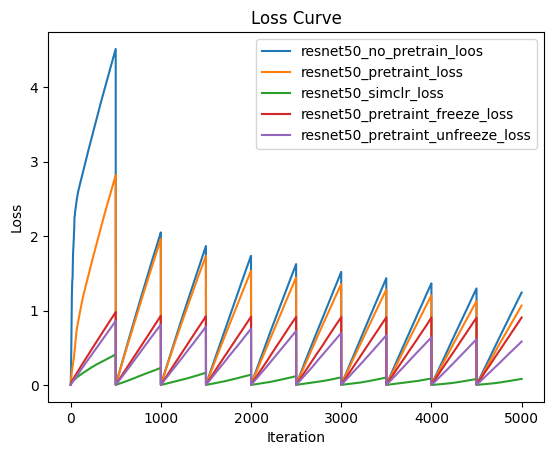

In [12]:
import matplotlib.pyplot as plt

# Extract the loss values from the loss_dict
loss_values = [values for values in loss_dict.values()]

# Plot the loss values for each key
for key, values in loss_dict.items():
    plt.plot(values, label=key)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()